In [1]:
!pip install --quiet transformers datasets accelerate
!pip install --quiet transformers[torch]
!pip install --quiet accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 

# Fine tuning a pre-trained model

- How to prepare a large dataset from the Hub
- How to use the high-level Trainer API to fine-tune a model
- How to use a custom training loop
- How to leverage the 🤗 Accelerate library to easily run that custom training loop on any distributed setup

# 1. Processing the data

In this section we will use as an example the MRPC (Microsoft Research Paraphrase Corpus) dataset, introduced in a paper by William B. Dolan and Chris Brockett. The dataset consists of 5,801 pairs of sentences, with a label indicating if they are paraphrases or not (i.e., if both sentences mean the same thing). We’ve selected it for this chapter because it’s a small dataset, so it’s easy to experiment with training on it.

**Loading a dataset from the hub**

The Hub doesn’t just contain models; it also has multiple datasets in lots of different languages. You can browse the datasets [here](https://huggingface.co/datasets), and we recommend you try to load and process a new dataset once you have gone through this section (see the general documentation [here](https://huggingface.co/docs/datasets/loading)). But for now, let’s focus on the MRPC dataset! This is one of the 10 datasets composing the GLUE benchmark, which is an academic benchmark that is used to measure the performance of ML models across 10 different text classification tasks.

The 🤗 Datasets library provides a very simple command to download and cache a dataset on the Hub. We can download the MRPC dataset like this:

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

As you can see, we get a DatasetDict object which contains the training set, the validation set, and the test set. Each of those contains several columns (sentence1, sentence2, label, and idx) and a variable number of rows, which are the number of elements in each set (so, there are 3,668 pairs of sentences in the training set, 408 in the validation set, and 1,725 in the test set).

This command downloads and caches the dataset, by default in `~/.cache/huggingface/datasets`. Recall from Chapter 2 that you can customize your cache folder by setting the HF_HOME environment variable.

We can access each pair of sentences in our raw_datasets object by indexing, like with a dictionary:

In [3]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

We can see the labels are already integers, so we won’t have to do any preprocessing there. To know which integer corresponds to which label, we can inspect the features of our `raw_train_dataset`.

In [4]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

Behind the scenes, label is of type ClassLabel, and the mapping of integers to label name is stored in the names folder. 0 corresponds to not_equivalent, and 1 corresponds to equivalent.

**Preprocessing a dataset**

To preprocess the dataset, we need to convert the text to numbers the model can make sense of. As you saw in the previous chapter, this is done with a tokenizer. We can feed the tokenizer one sentence or a list of sentences, so we can directly tokenize all the first sentences and all the second sentences of each pair like this:

In [5]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

However, we can’t just pass two sequences to the model and get a prediction of whether the two sentences are paraphrases or not. We need to handle the two sequences as a pair, and apply the appropriate preprocessing. Fortunately, the tokenizer can also take a pair of sequences and prepare it the way our BERT model expects:

In [6]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

`token_type_ids` is what tells the model which part of the input is the first sentence and which is the second sentence.

If we decode the IDs inside `input_ids` back to words:



In [7]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

As you can see, the parts of the input corresponding to [CLS] sentence1 [SEP] all have a token type ID of 0, while the other parts, corresponding to sentence2 [SEP], all have a token type ID of 1.

Note that if you select a different checkpoint, you won’t necessarily have the token_type_ids in your tokenized inputs (for instance, they’re not returned if you use a DistilBERT model). They are only returned when the model will know what to do with them, because it has seen them during its pretraining.

BERT is pretrained using token type IDs and an additional objective called `next sentence prediction (NSP)` alongside the masked language modeling (MLM) objective. NSP involves providing the model with pairs of sentences and predicting whether the second sentence follows the first. Half the pairs follow the original document order, and half are from different documents.

You don't need to worry about token_type_ids in tokenized inputs as long as the same checkpoint is used for both the tokenizer and model. To tokenize a dataset, you can feed the tokenizer a list of sentence pairs, compatible with padding and truncation options. This method can be used to preprocess the training dataset.

In [8]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
)

The current method of tokenization returns a dictionary with keys like `input_ids`, `attention_mask`, and `token_type_ids`, and their values are lists of lists. This approach requires enough RAM to store the entire dataset during tokenization, unlike the 🤗 Datasets library which uses Apache Arrow files to keep most data on disk, only loading requested samples into memory.

To address this, we can use the `Dataset.map()` method, which maintains the data as a dataset and offers more flexibility for additional preprocessing. The `map()` method applies a function to each element of the dataset, so we'll define a function for tokenizing the inputs.

In [9]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

This function processes a dictionary by returning a new dictionary with the keys `input_ids`, `attention_mask`, and `token_type_ids`. It handles multiple samples efficiently by working on lists of sentence pairs, allowing the use of `batched=True` in the `map()` call to speed up tokenization. The tokenizer, from the 🤗 [Tokenizers](https://github.com/huggingface/tokenizers) library and written in Rust, performs well with large inputs.

Padding is omitted during tokenization to avoid inefficiency. Padding is done while building a batch to match the maximum length within that batch, rather than the entire dataset, saving time and processing power. Using `batched=True` in the `map` function applies the tokenization to multiple dataset elements simultaneously, enhancing preprocessing speed.

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

You can use multiprocessing to speed up your preprocessing function with `map()` by specifying the `num_proc` argument. This isn't necessary when using the 🤗 Tokenizers library, as it already employs multiple threads for faster tokenization. The `tokenize_function` returns a dictionary with `input_ids`, `attention_mask`, and `token_type_ids`, adding these fields to all dataset splits. You can also update existing fields if the preprocessing function returns new values for existing keys. Lastly, dynamic padding is needed to pad all examples to the length of the longest element when batching them together.

**Dynamic padding**

The `collate function` is responsible for assembling samples into a batch for a DataLoader. By default, it converts samples to PyTorch tensors and concatenates them, which is not suitable if samples vary in size. To handle variable input sizes and avoid excessive padding, padding is applied as needed for each batch, improving training speed.

However, this can be problematic for TPU training, which prefers fixed shapes. The 🤗 Transformers library offers DataCollatorWithPadding, which automatically handles padding based on the provided tokenizer, accommodating model-specific padding requirements.

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
# Here, we remove the columns idx, sentence1, and sentence2 as they won’t be needed
# and contain strings (and we can’t create tensors with strings) and have a look at the lengths
# of each entry in the batch:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

No surprise, we get samples of varying length, from 32 to 67. Dynamic padding means the samples in this batch should all be padded to a length of 67, the maximum length inside the batch. Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept. Let’s double-check that our data_collator is dynamically padding the batch properly:

In [13]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

Looking good! Now that we’ve gone from raw text to batches our model can deal with, we’re ready to fine-tune it!



# 2. Fine-tuning a model with the trainer API or Keras

🤗 Transformers provides a Trainer class to help you fine-tune any of the pretrained models it provides on your dataset. Once you’ve done all the data preprocessing work in the last section, you have just a few steps left to define the Trainer. The hardest part is likely to be preparing the environment to run Trainer.train(), as it will run very slowly on a CPU. If you don’t have a GPU set up, you can get access to free GPUs or TPUs on Google Colab.

**Training**

The first step before we can define our Trainer is to define a TrainingArguments class that will contain all the hyperparameters the Trainer will use for training and evaluation. The only argument you have to provide is a directory where the trained model will be saved, as well as the checkpoints along the way. For all the rest, you can leave the defaults, which should work pretty well for a basic fine-tuning.

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [15]:
# define our model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Once we have our model, we can define a Trainer by passing it all the objects constructed up to now — the model, the training_args, the training and validation datasets, our data_collator, and our tokenizer:

In [16]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Note that when you pass the tokenizer as we did here, the default data_collator used by the Trainer will be a DataCollatorWithPadding as defined previously, so you can skip the line data_collator=data_collator in this call. It was still important to show you this part of the processing in section 2!

To fine-tune the model on our dataset, we just have to call the train() method of our Trainer:

In [17]:
trainer.train()

Step,Training Loss
500,0.519800
1000,0.239300


TrainOutput(global_step=1377, training_loss=0.30278645101975254, metrics={'train_runtime': 243.0352, 'train_samples_per_second': 45.277, 'train_steps_per_second': 5.666, 'total_flos': 405114969714960.0, 'train_loss': 0.30278645101975254, 'epoch': 3.0})

This will start the fine-tuning (which should take a couple of minutes on a GPU) and report the training loss every 500 steps. It won’t, however, tell you how well (or badly) your model is performing. This is because:

1. We didn’t tell the Trainer to evaluate during training by setting evaluation_strategy to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).

2. We didn’t provide the Trainer with a compute_metrics() function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

**Evaluation**

To build a useful `compute_metrics()` function for evaluating model performance during training, follow these steps:

1. The function should take an `EvalPrediction` object as input. This object is a named tuple with `predictions` and `label_ids` fields.
2. The function should return a dictionary where:
   - Keys are metric names (strings).
   - Values are the corresponding metric values (floats).
3. To generate predictions from the model, use the `Trainer.predict()` command.

In [18]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(408, 2) (408,)


The `predict()` method returns a named tuple with three fields: `predictions`, `label_ids`, and `metrics`. The `metrics` field includes the dataset loss and time metrics (total and average prediction time). After implementing and passing the `compute_metrics()` function to the Trainer, `metrics` will also include additional computed metrics.

The `predictions` field is a 2D array with a shape of 408 x 2, representing the logits for each of the 408 elements in the dataset. To convert these logits into actual predictions, we need to select the index with the maximum value along the second axis.

In [19]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

We can now compare those preds to the labels. To build our compute_metric() function, we will rely on the metrics from the 🤗 [Evaluate](https://github.com/huggingface/evaluate/) library. We can load the metrics associated with the MRPC dataset as easily as we loaded the dataset, this time with the evaluate.load() function. The object returned has a compute() method we can use to do the metric calculation:

In [20]:
!pip install --quiet evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [21]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8431372549019608, 'f1': 0.8885017421602788}

The exact results you get may vary, as the random initialization of the model head might change the metrics it achieved. Here, we can see our model has an accuracy of 85.78% on the validation set and an F1 score of 89.97. Those are the two metrics used to evaluate results on the MRPC dataset for the GLUE benchmark. The table in the BERT paper reported an F1 score of 88.9 for the base model. That was the uncased model while we are currently using the cased model, which explains the better result.

Wrapping everything together, we get our compute_metrics() function:



In [22]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note that we create a new TrainingArguments with its evaluation_strategy set to "epoch" and a new model — otherwise, we would just be continuing the training of the model we have already trained.

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.371126,0.857843,0.901024
2,0.527200,0.459970,0.845588,0.893401
3,0.279600,0.774146,0.848039,0.894915


TrainOutput(global_step=1377, training_loss=0.3341553964386319, metrics={'train_runtime': 245.4461, 'train_samples_per_second': 44.833, 'train_steps_per_second': 5.61, 'total_flos': 405114969714960.0, 'train_loss': 0.3341553964386319, 'epoch': 3.0})

The validation loss and metrics will be reported at the end of each epoch in addition to the training loss. The exact accuracy or F1 score may vary due to the random initialization of the model's head, but should be similar overall. The Trainer can run on multiple GPUs or TPUs and supports various options, including mixed-precision training. More details will be covered in Chapter 10.

# 3. A full training

Now we’ll see how to achieve the same results as we did in the last section without using the Trainer class. Again, we assume you have done the data processing in section 2. Here is a short summary covering everything you will need:

In [25]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

**Prepare for training**

Before actually writing our training loop, we will need to define a few objects. The first ones are the dataloaders we will use to iterate over batches. But before we can define those dataloaders, we need to apply a bit of postprocessing to our tokenized_datasets, to take care of some things that the Trainer did for us automatically. Specifically, we need to:

- Remove the columns corresponding to values the model does not expect (like the sentence1 and sentence2 columns).
- Rename the column label to labels (because the model expects the argument to be named labels).
- Set the format of the datasets so they return PyTorch tensors instead of lists.

Our tokenized_datasets has one method for each of those steps:

In [26]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [28]:
# quickly check there is no mistake in the data processing
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 81]),
 'token_type_ids': torch.Size([8, 81]),
 'attention_mask': torch.Size([8, 81])}

Note that the actual shapes will probably be slightly different for you since we set shuffle=True for the training dataloader and we are padding to the maximum length inside the batch.

Now that we’re completely finished with data preprocessing (a satisfying yet elusive goal for any ML practitioner), let’s turn to the model.

In [29]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.9363, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


All 🤗 Transformers models will return the loss when labels are provided, and we also get the logits (two for each input in our batch, so a tensor of size 8 x 2).

We’re almost ready to write our training loop! We’re just missing two things: an optimizer and a learning rate scheduler. Since we are trying to replicate what the Trainer was doing by hand, we will use the same defaults. The optimizer used by the Trainer is AdamW, which is the same as Adam, but with a twist for weight decay regularization (see [“Decoupled Weight Decay Regularization”](https://arxiv.org/abs/1711.05101) by Ilya Loshchilov and Frank Hutter):

In [31]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Finally, the learning rate scheduler used by default is just a linear decay from the maximum value (5e-5) to 0. To properly define it, we need to know the number of training steps we will take, which is the number of epochs we want to run multiplied by the number of training batches (which is the length of our training dataloader). The Trainer uses three epochs by default, so we will follow that:

In [32]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


**The training loop**

One last thing: we will want to use the GPU if we have access to one (on a CPU, training might take several hours instead of a couple of minutes). To do this, we define a device we will put our model and our batches on:

In [33]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [34]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1377 [00:00<?, ?it/s]

**The evaluation loop**

As we did earlier, we will use a metric provided by the 🤗 Evaluate library. We’ve already seen the metric.compute() method, but metrics can actually accumulate batches for us as we go over the prediction loop with the method add_batch(). Once we have accumulated all the batches, we can get the final result with metric.compute().

In [35]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.8725490196078431, 'f1': 0.9109589041095889}

**Supercharge your training loop with  🤗 Accelerate**

The training loop we defined earlier works fine on a single CPU or GPU. But using the 🤗 Accelerate library, with just a few adjustments we can enable distributed training on multiple GPUs or TPUs. Starting from the creation of the training and validation dataloaders, here is what our manual training loop looks like:

In [36]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1377 [00:00<?, ?it/s]

The changes:

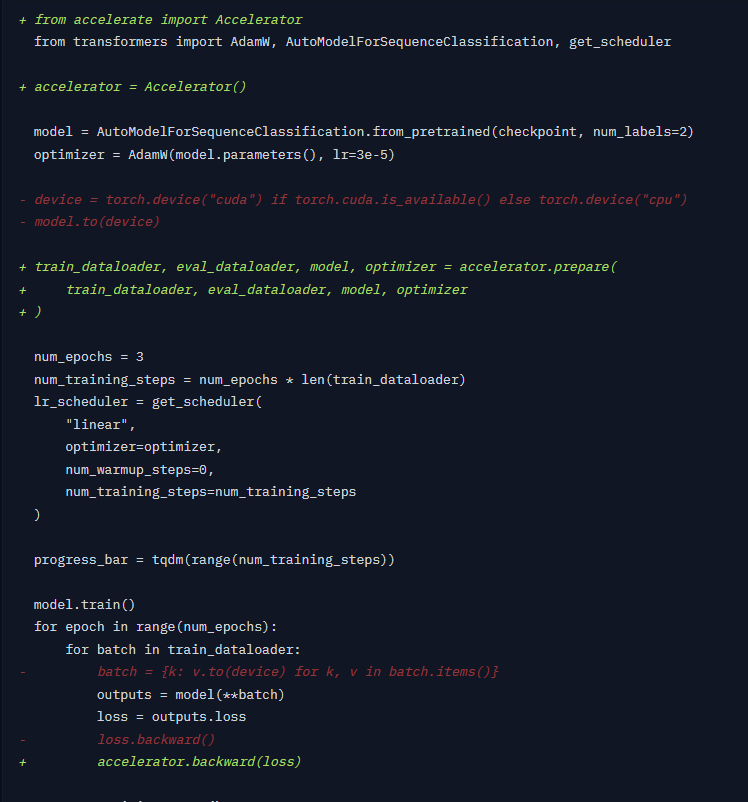

The process to integrate Accelerate into your code involves several key steps for optimizing distributed training. First, you import the necessary modules. Next, you instantiate an Accelerator object, which automates environment setup for distributed training. Accelerate manages device placement, eliminating the need for manual device assignments.

The core modification is applying `accelerator.prepare()` to your dataloaders, model, and optimizer. This action ensures proper container wrapping for distributed training functionality. Further adjustments include removing direct batch-to-device operations (replacing with `accelerator.device` if desired) and replacing `loss.backward()` with `accelerator.backward(loss)`.

⚠️ For optimal performance on Cloud TPUs, it's advised to pad samples to a fixed length using tokenizer arguments `padding="max_length"` and specifying `max_length`.

If you’d like to copy and paste it to play around, here’s what the complete training loop looks like with 🤗 Accelerate:

In [37]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1377 [00:00<?, ?it/s]

Putting this in a train.py script will make that script runnable on any kind of distributed setup. To try it out in your distributed setup, run the command:

`accelerate config`

which will prompt you to answer a few questions and dump your answers in a configuration file used by this command:

`accelerate launch train.py`

which will launch the distributed training.

If you want to try this in a Notebook (for instance, to test it with TPUs on Colab), just paste the code in a training_function() and run a last cell with:

```
from accelerate import notebook_launcher

notebook_launcher(training_function)
```

You can find more examples in the [🤗 Accelerate repo](https://github.com/huggingface/accelerate/tree/main/examples).